This notebook investigates the student population given incoming attributes

# Preparing the data
We need to load pre survey (incoming attitudes), post survey (demographics data), and worksheet (incoming knowledge).

In [1]:
from IPython.display import display
from IPython.display import HTML
import IPython.core.display as di

# This line will hide code by default when the notebook is converted to HTML
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

In [2]:
%load_ext autoreload
%autoreload 1
%aimport utils_read_parsing
%aimport utils_timeline_viz
from utils_timeline_viz import *
from utils_read_parsing import *
import matplotlib.pyplot as plt
from tabulate import tabulate
from scipy.stats import ranksums
import seaborn as sns
import statsmodels.api as sm
pd.set_option("display.width", 100)
import matplotlib.pyplot as plt
from statsmodels.formula.api import ols
from statsmodels.graphics.api import interaction_plot, abline_plot
from statsmodels.stats.anova import anova_lm
from statsmodels.discrete.discrete_model import Logit
from sklearn import decomposition
%matplotlib inline
matplotlib.style.use('ggplot')
matplotlib.rcParams['figure.figsize'] = 10, 6
pd.set_option('precision',3)
pd.set_option("display.width", 100)
pd.set_option('display.max_columns', 60)
np.set_printoptions(precision=3,suppress=True)

## Loading all the data sources

In [3]:
%reload_ext utils_read_parsing
pre_survey_df = get_massaged_pre_survey()
post_survey_df = get_massaged_post_survey()
worksheet_df = get_massaged_worksheet_model_data()

## Merging the data

In [4]:
post_survey_df = post_survey_df[['age','english.0-writing','english.1-reading','gender-Gender non conforming/non-binary','gender-Man','gender-Prefer not to answer','gender-Woman','major','year-1st year undergraduate','year-2nd year undergraduate','year-3rd year undergraduate','year-4th year undergraduate','sim','sim_index','sid']]
post_survey_df.fillna(0,inplace=True)
post_survey_df = post_survey_df[post_survey_df['sim_index']==2]
data = pre_survey_df.merge(post_survey_df, how='outer', on=['sid']);

In [5]:
worksheet_df = get_massaged_worksheet_highest_understanding_data()
pre_know = worksheet_df[['sid','variable','pre_highest']].pivot(index='sid', columns='variable')
data = data.merge(pre_know['pre_highest'], how='outer', on=['sid']);

In [6]:
data.rename(columns={"sim": "second sim"},inplace=True)
# data.sort_values('sid').head(12)

## Convert lickert scale and other values from strings to integers

In [7]:
value_converter2 = {
    'Prefer not to answer':0,
    '20-22':21,
    '18-19':19,
    '17 and under':17,
    'Fluent':3,
    'Average':2,
    'Beginner':1,
    'Absorbance':2,
    'Capacitance':1,
    'Not at all':1,
    'Definitely':4,
    'Somewhat':2,
    'Mostly':3,
    'Almost always':4,
    'Sometimes':2,
    'Almost never':1,
    'Often':3,
}

In [8]:
for value,replacement in value_converter2.iteritems():
    data = data.replace(value,replacement)
data.fillna(0,inplace=True)
data.head()

,[prior_lab] What lab courses are you presently taking or have taken in the past? Check all that apply. [High school level laboratory],[prior_lab] What lab courses are you presently taking or have taken in the past? Check all that apply. [First year undergraduate physics laboratory],[prior_lab] What lab courses are you presently taking or have taken in the past? Check all that apply. [First year undergraduate chemistry laboratory],[prior_lab] What lab courses are you presently taking or have taken in the past? Check all that apply. [Higher level chemistry labs],similar_L,similar_C,same_L,same_C,prior_number_virtual_labs,perceivedvalue.0-boring,perceivedvalue.1-productive,perceivedvalue.2-useless,perceivedvalue.3-engaging,taskinterpretation.0-investigate the basic mechanics of the topic at hand,taskinterpretation.1-design my own experiments that can help me understand the topic at hand,taskinterpretation.2-memorize information about the topic at hand,taskinterpretation.3-complete a certain number of questions,taskinterpretation.4-develop scientific reasoning skills,pocc.0-learning the basic concepts,pocc.1-testing my ideas and theories,pocc.2-answering given questions,pocc.3-memorizing key information,pocc.4-exploring the topic,sid,age,english.0-writing,english.1-reading,gender-Gender non conforming/non-binary,gender-Man,gender-Prefer not to answer,gender-Woman,major,year-1st year undergraduate,year-2nd year undergraduate,year-3rd year undergraduate,year-4th year undergraduate,second sim,sim_index,Area,Battery voltage,Concentration,Separation,Wavelength,Width
0,1.0,1.0,1.0,0.0,0,0,0,0,2,3.0,2.0,1,2.0,3,2,3,2,2.0,3,3,3,2,3,77047160,19,3,3,0.0,0.0,0.0,1.0,*Non science or applied science major,1.0,0.0,0.0,0.0,C,2,1.0,1.0,1.0,0.0,1.0,1.0
1,1.0,1.0,0.0,0.0,0,0,0,0,0,2.0,4.0,1,3.0,4,4,3,4,4.0,3,2,2,2,3,23836160,19,2,2,0.0,1.0,0.0,0.0,Civil Engineering,1.0,0.0,0.0,0.0,L,2,0.0,3.0,1.0,0.0,1.0,1.0
2,0.0,1.0,1.0,0.0,0,0,0,0,1,1.0,2.0,1,2.0,2,2,2,3,2.0,3,3,3,3,2,64006159,21,2,2,0.0,0.0,0.0,1.0,*Undeclared,0.0,1.0,0.0,0.0,C,2,1.0,2.0,2.0,1.0,1.0,0.0
3,1.0,1.0,1.0,0.0,0,1,0,0,3,2.0,3.0,1,3.0,3,4,3,4,3.0,4,4,3,3,3,24566161,19,3,3,0.0,1.0,0.0,0.0,Engineering Physics,1.0,0.0,0.0,0.0,L,2,2.0,3.0,2.0,2.0,1.0,2.0
4,0.0,1.0,0.0,0.0,1,0,0,0,2,2.0,3.0,1,3.0,4,2,1,3,4.0,3,3,3,2,4,46792161,19,3,3,0.0,1.0,0.0,0.0,Mechanical Engineering,1.0,0.0,0.0,0.0,C,2,3.0,3.0,2.0,3.0,1.0,2.0


In [9]:
for c in data.columns:
    if data[c].dtype not in ['int64','float64']:
        print c, data[c].dtype

major object
second sim object


We could remove the "major" if we wanted to...

In [10]:
# data.drop('major',axis=1,inplace=True)

# Analysis of all attributes

In [11]:
N = len(set(data['sid']))
print "The study includes {0} students.".format(N)

The study includes 148 students.


In [12]:
demo_columns = ["age","english.0-writing","english.1-reading","gender-Gender non conforming/non-binary","gender-Man","gender-Prefer not to answer","gender-Woman","year-1st year undergraduate","year-2nd year undergraduate","year-3rd year undergraduate","year-4th year undergraduate","second sim","[prior_lab] What lab courses are you presently taking or have taken in the past? Check all that apply. [High school level laboratory]","[prior_lab] What lab courses are you presently taking or have taken in the past? Check all that apply. [First year undergraduate physics laboratory]","[prior_lab] What lab courses are you presently taking or have taken in the past? Check all that apply. [First year undergraduate chemistry laboratory]","[prior_lab] What lab courses are you presently taking or have taken in the past? Check all that apply. [Higher level chemistry labs]","similar_L","similar_C","same_L","same_C","prior_number_virtual_labs","major"]
pv_columns = ["perceivedvalue.0-boring","perceivedvalue.1-productive","perceivedvalue.2-useless","perceivedvalue.3-engaging"]
ti_columns = ["taskinterpretation.0-investigate the basic mechanics of the topic at hand","taskinterpretation.1-design my own experiments that can help me understand the topic at hand","taskinterpretation.2-memorize information about the topic at hand","taskinterpretation.3-complete a certain number of  questions","taskinterpretation.4-develop scientific reasoning skills"]
pocc_columns = ["pocc.0-learning the basic concepts","pocc.1-testing my ideas and theories","pocc.2-answering given questions","pocc.3-memorizing key information","pocc.4-exploring the topic"]
know_columns = ['Concentration','Wavelength','Width','Area','Separation','Battery voltage']
att_columns = pv_columns + ti_columns + pocc_columns 
all_columns = demo_columns + att_columns + know_columns

## Some descriptives

### Incoming Attitudes

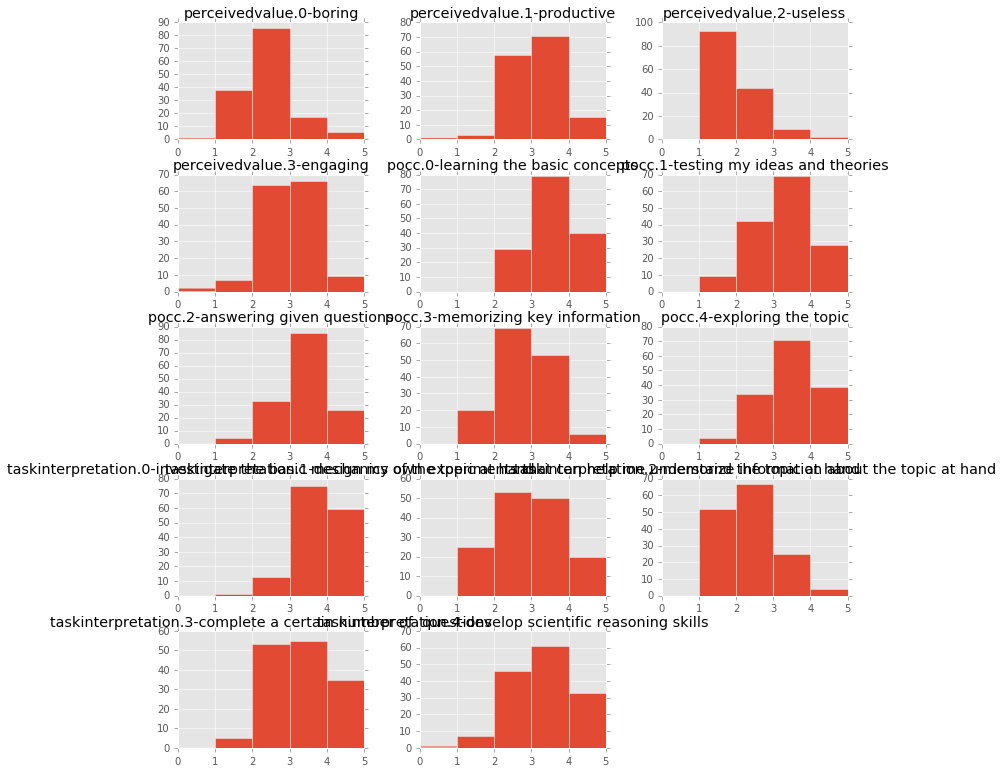

In [13]:
data[att_columns].hist(figsize=(12,13),layout=(len(att_columns)/3+1,3),bins=[0,1,2,3,4,5]);

Overall, many students thought the activity would be productive and engaging. Some thought they would be able to explore the topic and test their theories. Many interpreted the task as "answer a certain number of questions".

### Incoming knowledge

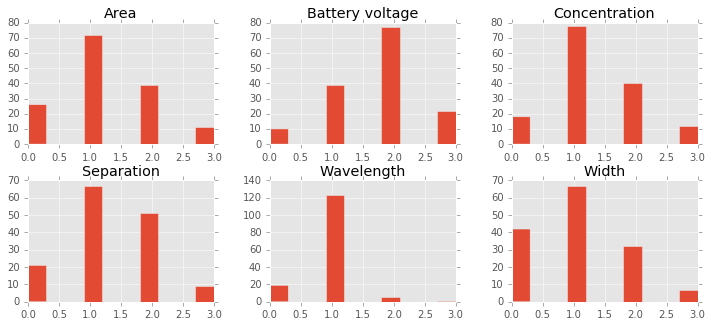

In [14]:
data[know_columns].hist(figsize=(12,5),layout=(2,3));

The quantitative variables look pretty similar. Few know how to predict Wavelength however they know it's relevant (lots of 1s). Battery voltage seems to be a variable tha many describe qualitatively.

### Demographics

See storyline_journal_paper notebook for details. Essentially, most students are first years (76%) with undeclared majors (52%), are fluent in English, have experience with virtual labs and experimental lab classes.

## Overall correlations between attributes

We remove columns that are obviously going to be highly correlated ("Man" wih other gender columns and "1st year undergraduate" with other undergraduate year columns, "english-reading" with "writing")

In [15]:
all_columns_for_correlation = list(all_columns)
all_columns_for_correlation.remove('gender-Man')
all_columns_for_correlation.remove('year-1st year undergraduate')
all_columns_for_correlation.remove('english.1-reading')

D:\Applications\Anaconda2\lib\site-packages\scipy\stats\stats.py:253: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  "values. nan values will be ignored.", RuntimeWarning)


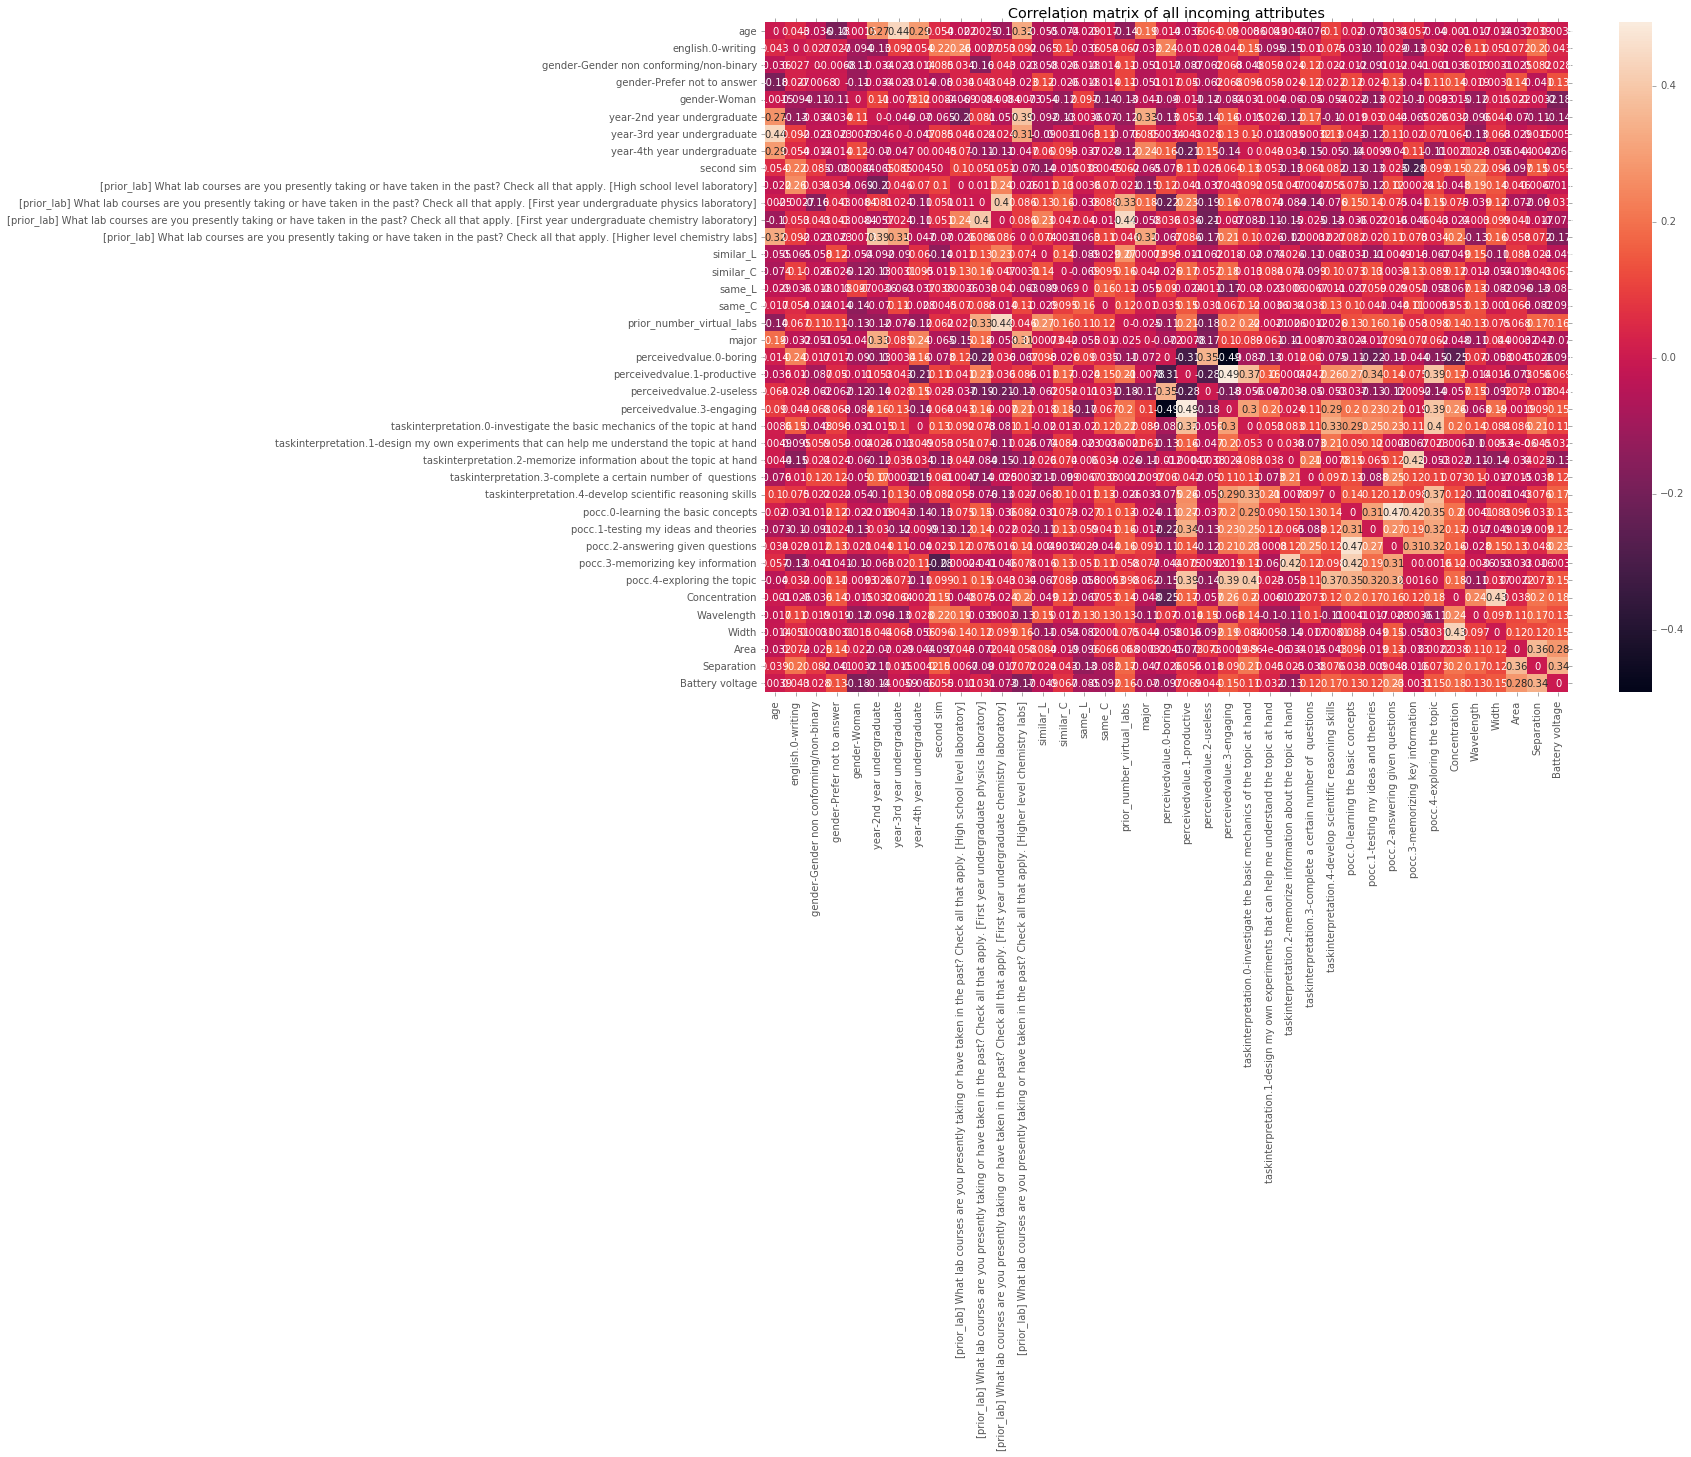

In [16]:
from scipy.stats import spearmanr
fig, ax = plt.subplots(figsize=(18,12)) 
correlation_matrix = np.zeros((len(all_columns_for_correlation),len(all_columns_for_correlation)))
for i,att_i in enumerate(all_columns_for_correlation):
    for j,att_j in enumerate(all_columns_for_correlation):
        r,p = spearmanr(data[att_i],data[att_j])
        correlation_matrix[i,j] = r

np.fill_diagonal(correlation_matrix,0)
plt.title("Correlation matrix of all incoming attributes")
sns.heatmap(correlation_matrix,ax=ax,yticklabels=all_columns_for_correlation,xticklabels=all_columns_for_correlation,annot=True);

Taking into consideration that we are doing 38\*38 correlations and some are going to be from random chance, here are a few observations:
* Age is correlated to Undergraduate year and 2nd year+ chemistry labs (duh)
* Gender doesn't seem to be correlated with anything (yay!)
* The fact that students have used similar or the same virtual labs before doesn't correlated with anything
* The number of prior virtual labs done by students is correlated to having taken or taking first year chem and physics lab courses.
* A lot of attitudinal measures are correlated. We will investigate this in more depth later
* Some incoming knowledge seems to be correlated bery slightly with perceived value. For example, Concentration knowledge is correlated with the activity being engaging but not boring. (Keep in mind students got different screenshots of the virtual lab depending on activity order).
* Some incoming knowledge on different variables are correlated. We will investigate this next.

Overall no correlations seem to be out of the ordinary or troubling.

# Analysis of incoming attitudes

Clearly, many attitude questions are related from our descriptives. Let's investigate how much:

### Relationship between attitude measures

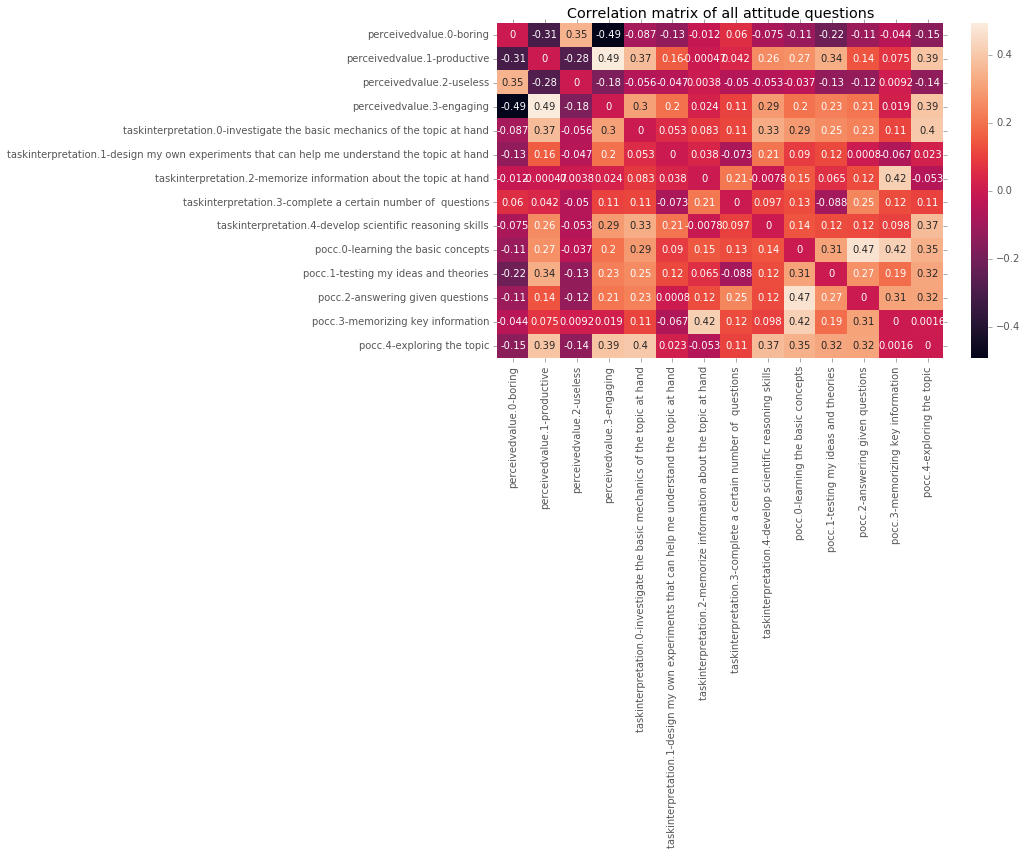

In [17]:
from scipy.stats import spearmanr
correlation_matrix = np.zeros((len(att_columns),len(att_columns)))
for i,att_i in enumerate(att_columns):
    for j,att_j in enumerate(att_columns):
        r,p = spearmanr(data[att_i],data[att_j])
        correlation_matrix[i,j] = r

np.fill_diagonal(correlation_matrix,0)
plt.title("Correlation matrix of all attitude questions")
sns.heatmap(correlation_matrix,yticklabels=att_columns,xticklabels=att_columns,annot=True);

All the POCC type questions are highly correlated between each other (0.3,0.4).
All the perveiced value questions are also highly correlated or anti-correlated (0.3,0.4) which is great since they were deisgned that way ("Do you think the activity will be productive/useless, boring/engaging"). What is interesting is that if they find it productive they also find it engaging.

### Reliability scores of attitude questions

To get good reliability measures, we need to reverse some questions values with negative correlations to everything else

In [18]:
data['perceivedvalue.0-boring_reversed'] = 4-data['perceivedvalue.0-boring']
data['perceivedvalue.2-useless_reversed'] = 4-data['perceivedvalue.2-useless']
pv_fixed_columns = ["perceivedvalue.0-boring_reversed","perceivedvalue.1-productive","perceivedvalue.2-useless_reversed","perceivedvalue.3-engaging"]

In [19]:
def cronbach_alpha(scores):
    if scores.isnull().values.any():
        print "Cannot compute Cronbach alpha: your dataframe has NaN values."
        return
    K = scores.shape[1]
    sum_of_var = float(scores.apply(lambda x: np.var(x,ddof=1), axis=0).sum())
    var = float(np.var(scores.sum(axis=1),ddof=1))
    alpha = (K/float(K-1.0))*(1.0-sum_of_var/var)
    return round(alpha,2)

In [20]:
t = [['questions combined','reliability score']]
t.append(['all (14)',cronbach_alpha(data[att_columns]) ])
t.append(['POCC (5)',cronbach_alpha(data[att_columns]) ])
t.append(['Perceived value (4)',cronbach_alpha(data[pv_fixed_columns]) ])
t.append(['Task interpretation (5)',cronbach_alpha(data[ti_columns]) ])
t.append(['Task interpretation and perceived value (9)',cronbach_alpha(data[ti_columns+pv_fixed_columns]) ])

print tabulate(t)

-------------------------------------------  -----------------
questions combined                           reliability score
all (14)                                     0.61
POCC (5)                                     0.61
Perceived value (4)                          0.66
Task interpretation (5)                      0.33
Task interpretation and perceived value (9)  0.57
-------------------------------------------  -----------------


### What are the principle factors of all attitude questions? (PCA)

In [21]:
columns_for_pc = att_columns
pca = decomposition.PCA(n_components=6)
pca.fit(data[columns_for_pc])
pca.explained_variance_ratio_.cumsum()

array([ 0.23 ,  0.366,  0.463,  0.555,  0.639,  0.702])

The first three components of the PCA exaplined almost 50% of the data. Let's stick to 2 to simplify our analysis

In [22]:
NC = 2
pca = decomposition.PCA(n_components=NC)
pca.fit(data[columns_for_pc])
X = pca.transform(data[columns_for_pc])
data['PC1'] = zip(*X)[0]
data['PC2'] = zip(*X)[1]

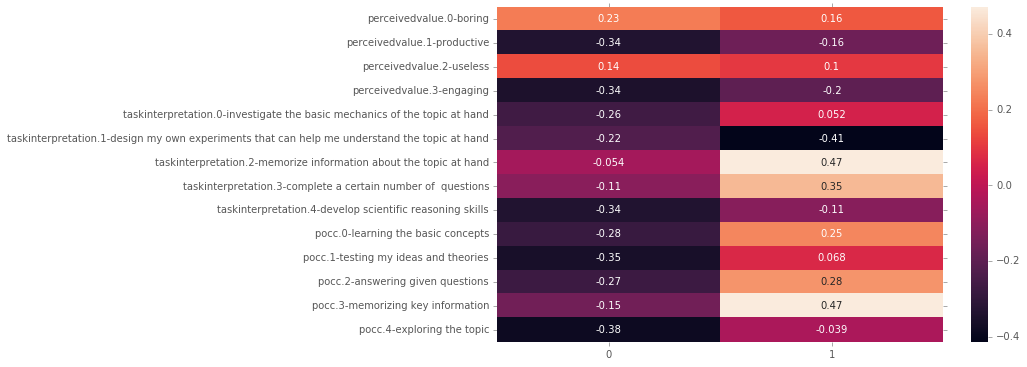

In [23]:
sns.heatmap(pca.components_.T,yticklabels=columns_for_pc,annot=True)

Looking at items that are part of the PC (by a factor of 0.3 percent). We can interpret the PC this way:

**PC 1** - Having a low PC1 means a student thinks:
* the activity will be engaging and productive
* the activity is design to develop scientific reasoning skills
* they can do a good job of exploring the topic and testing their ideas.
"the engaged explorers" have low PC1
"bored and not engaged" have high PC1

**PC 2** - Having a high PC2 means a student thinks:
* the activity is NOT designed to design their own experiments
* the activity is design to memorize information and complete a certain number of questions
* they can do a good job of memorizing key information
"the expecting to be assessed" have high PC1
"ready to design experiments and understand" have low PC1

Since the PCs are orthogonal, we have 4 types of students:
1. The engaged and expecting to be assessed (-+)
2. The engaged and looking for understanding (--)
3. The not engaged and looking for understanding (+-)
4. The not engaged and expecting to be assessed (++)

### What are the principle factors of task interpretation and perceived value? (PCA)

In [24]:
columns_for_pc = pv_columns + ti_columns
pca = decomposition.PCA(n_components=6)
pca.fit(data[columns_for_pc])
pca.explained_variance_ratio_.cumsum()

array([ 0.254,  0.413,  0.548,  0.67 ,  0.762,  0.841])

In [25]:
NC = 2
pca = decomposition.PCA(n_components=NC)
pca.fit(data[columns_for_pc])
X = pca.transform(data[columns_for_pc])
data['PC1_wo_pocc'] = zip(*X)[0]
data['PC2_wo_pocc'] = zip(*X)[1]

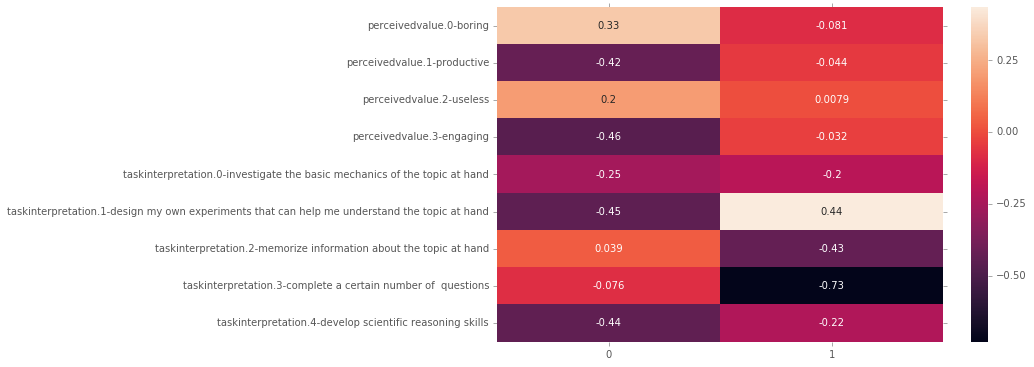

In [26]:
sns.heatmap(pca.components_.T,yticklabels=columns_for_pc,annot=True)

Looking at items that are part of the PC (by a factor of 0.3 percent). We can interpret the PC this way:

(low) **PC 1** - Students think:
* the activity will be engaging, productive
* the activity is design to develop scientific reasoning skills

(low) **PC 2** - Students think:
* the activity is not designed to design their own experiments
* the activity is designed to memorize information and complete a certain number of questions

### Investigating the two attitudinal groups in terms of overall POCC

In [27]:
# from sklearn.cluster import KMeans
# clusters = KMeans(n_clusters=2, n_init=10, verbose=0).fit(data[columns_for_pc])
# data['cluster_2_label'] = clusters.labels_

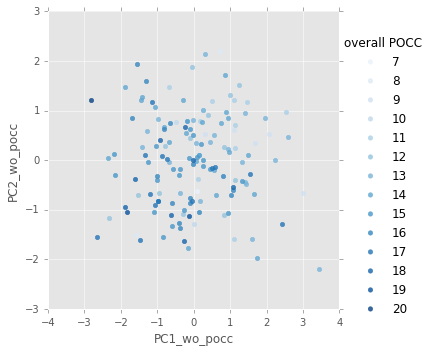

In [28]:
data['overall POCC'] = data[pocc_columns].sum(axis=1)
sns.lmplot(x='PC1_wo_pocc', y='PC2_wo_pocc',data=data,fit_reg=False,hue='overall POCC', palette="Blues")

D:\Applications\Anaconda2\lib\site-packages\matplotlib\axes\_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


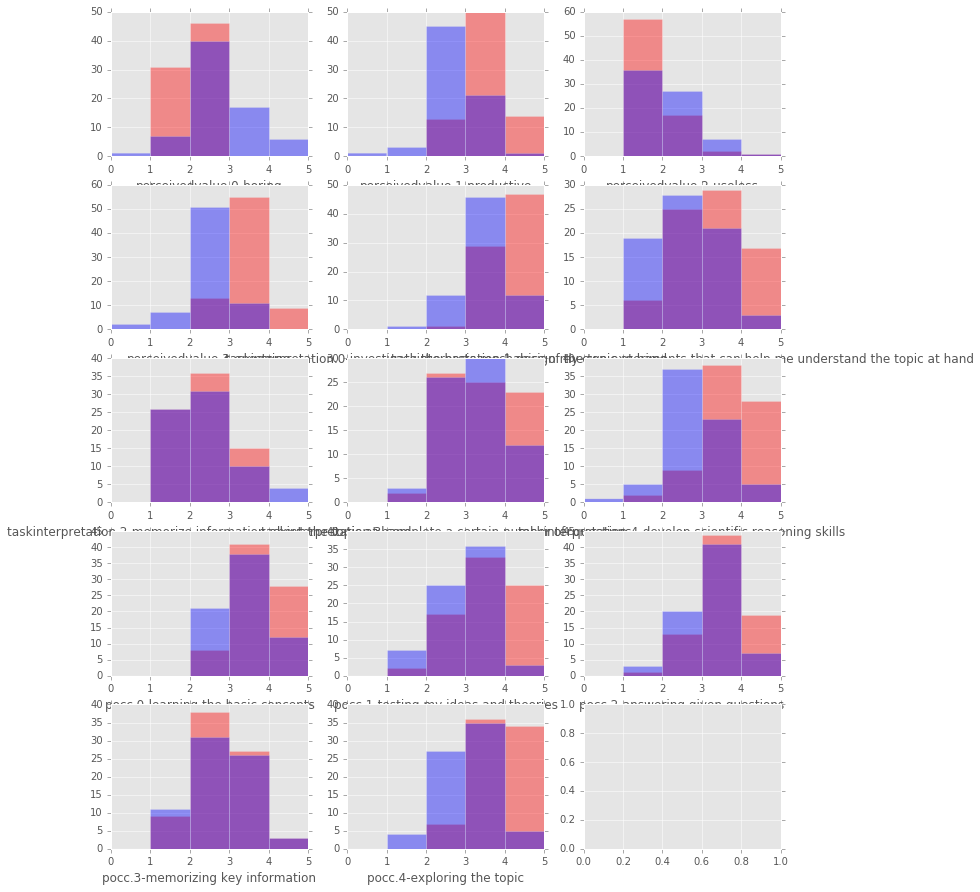

In [29]:
fig,axes = plt.subplots(nrows=len(att_columns)/3+1,ncols=3,figsize=(12,15))
for ax,col in zip(axes.reshape(-1),att_columns):
#     sns.distplot(data[data['cluster_2_label']==0][col],ax=ax,bins=[0,1,2,3,4,5],kde=False,label='0',color='red');
#     sns.distplot(data[data['cluster_2_label']==1][col],ax=ax,bins=[0,1,2,3,4,5],kde=False,label='1',color='blue');
    sns.distplot(data[data['PC1_wo_pocc']<0][col],ax=ax,bins=[0,1,2,3,4,5],kde=False,label='low PC1',color='red');
    sns.distplot(data[data['PC1_wo_pocc']>=0][col],ax=ax,bins=[0,1,2,3,4,5],kde=False,label='high PC1',color='blue');
plt.legend()

Clearly, the "red" students (low PC1) think:
* the activity will be productive and engaging
* the activity was design to develop scientific reasoning skills and test their ideas
* they can do a good job at the activity

Clearly, the "blue" students (high PC1) think:
* the activity will be boring, useless
* they tend to have a low perception of their control and competence

# Analysis of incoming knowledge

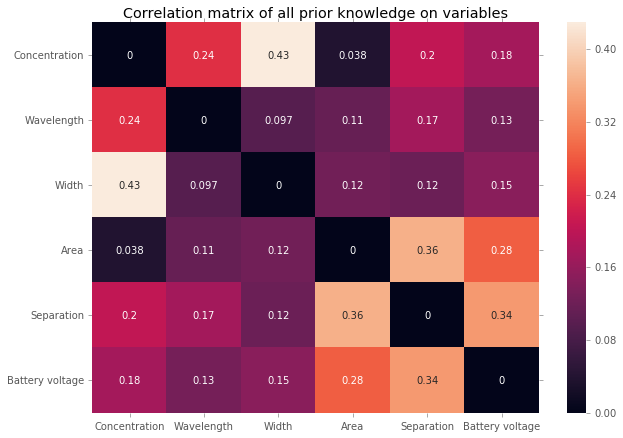

In [30]:
from scipy.stats import spearmanr
fig, ax = plt.subplots(figsize=(10,7)) 
correlation_matrix = np.zeros((len(know_columns),len(know_columns)))
for i,att_i in enumerate(know_columns):
    for j,att_j in enumerate(know_columns):
        r,p = spearmanr(data[att_i],data[att_j])
        correlation_matrix[i,j] = r

np.fill_diagonal(correlation_matrix,0)
plt.title("Correlation matrix of all prior knowledge on variables")
sns.heatmap(correlation_matrix,ax=ax,yticklabels=know_columns,xticklabels=know_columns,annot=True);

Clearly, knowledge of variables of the same sim are correlated, particularly Concentration and Width.

In [31]:
data['incoming_knowledge_L'] = (data['Concentration']+data['Width']+data['Wavelength'])
data['incoming_knowledge_C'] = (data['Area']+data['Separation']+data['Battery voltage'])
data['incoming_knowledge_all'] = (data['Area']+data['Separation']+data['Battery voltage']+data['Concentration']+data['Width']+data['Wavelength'])
data['incoming_knowledge_quant'] = (data['Area']+data['Separation']+data['Concentration']+data['Width'])

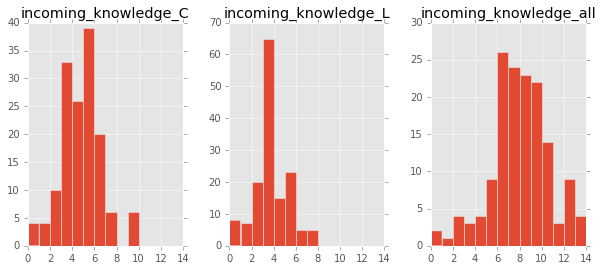

In [32]:
data[['incoming_knowledge_L','incoming_knowledge_C','incoming_knowledge_all']].hist(figsize=(10,4),layout=(1,3), bins = range(0,15));

We have a somewhat normal distribution.

# Analyzing all attributes

## Relating attitudes to incoming knowledge

Given ou PCA above for all attitude variables (TI, POCC, PV), let's see how incoming knowledge is related.

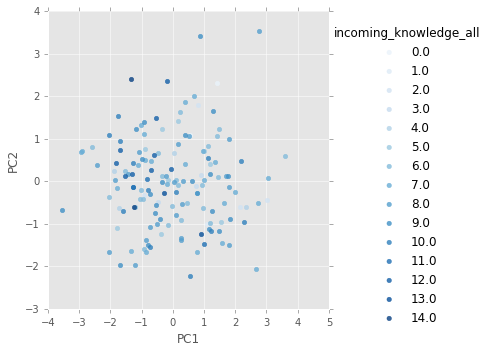

In [33]:
sns.lmplot(x='PC1', y='PC2',data=data,fit_reg=False,hue='incoming_knowledge_all', palette="Blues")

From our PCA of attitudes, there doesn't seem to be any natural forming groups in the data. When overlaying the total of their incoming knowledge score, there's no much trend. We notice that the high scoring students (dark blue) generally don't have a high PC1 and high PC2 (are not the boring and expecting to be assessed).

From this, we don't suspect to have well defined clusters in our dataset, but let's investigate with K-means and silhouette analysis.

## Kmeans clustering

We run clustering on all incoming factors (attitudes, knowledge, year undergradte, experimental labs exerience, virtual lab experience, english writing and reading fluency.

We remove age and Gender because one student answer "0" and "Prefer not to answer" for these questions. We also remove major since it's a qualitative variable

('For n_clusters =', 2, 'The average silhouette_score is :', 0.095727279840648563)
('For n_clusters =', 3, 'The average silhouette_score is :', 0.059749220192794043)
('For n_clusters =', 4, 'The average silhouette_score is :', 0.057225097879053034)
('For n_clusters =', 5, 'The average silhouette_score is :', 0.045322648616760386)


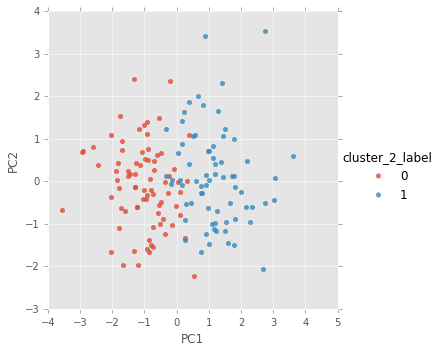

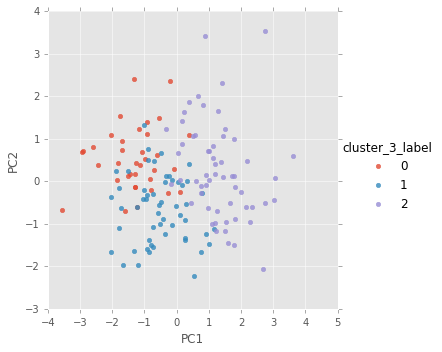

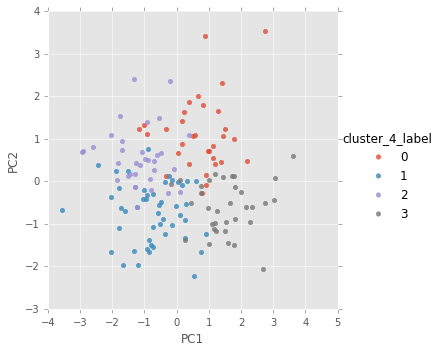

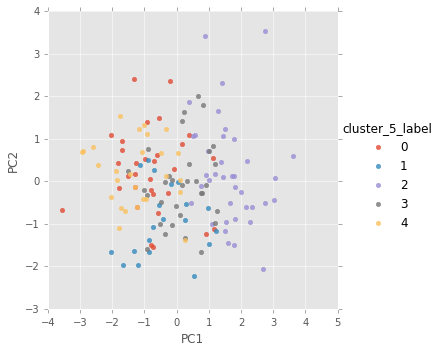

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

cluster_columns = [x for x in all_columns if x not in ['second sim','major','sid','age','gender-Gender non conforming/non-binary','gender-Man','gender-Prefer not to answer','gender-Woman']]

for i in [2,3,4,5]:
    y_pred = KMeans(n_clusters=i).fit_predict(data[cluster_columns])
    data['cluster_'+str(i)+'_label'] = y_pred
    silhouette_avg = silhouette_score(data[cluster_columns], y_pred)
    print("For n_clusters =",i,
          "The average silhouette_score is :", silhouette_avg)
    sns.lmplot(x='PC1', y='PC2',data=data,fit_reg=False,hue='cluster_'+str(i)+'_label')

Two clusters seems to follow PC 1 divisions. Three clusters as well. Though we still need to investigate what differentiates the clusters in terms of knowledge and education background. Four and five clusters gets messier...

HOWEVER, the silhouette scores are really low (max is 1, near 0 means most points are as close to a neighboring cluster than their own, negative means most points are closer to neighboring cluster).
For more info: https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html

All to say, our data doesn't have clusters... Other analysis (ex. hierarchical analysis) would probably lead to similar results.

## Picking 2 clusters

D:\Applications\Anaconda2\lib\site-packages\matplotlib\axes\_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


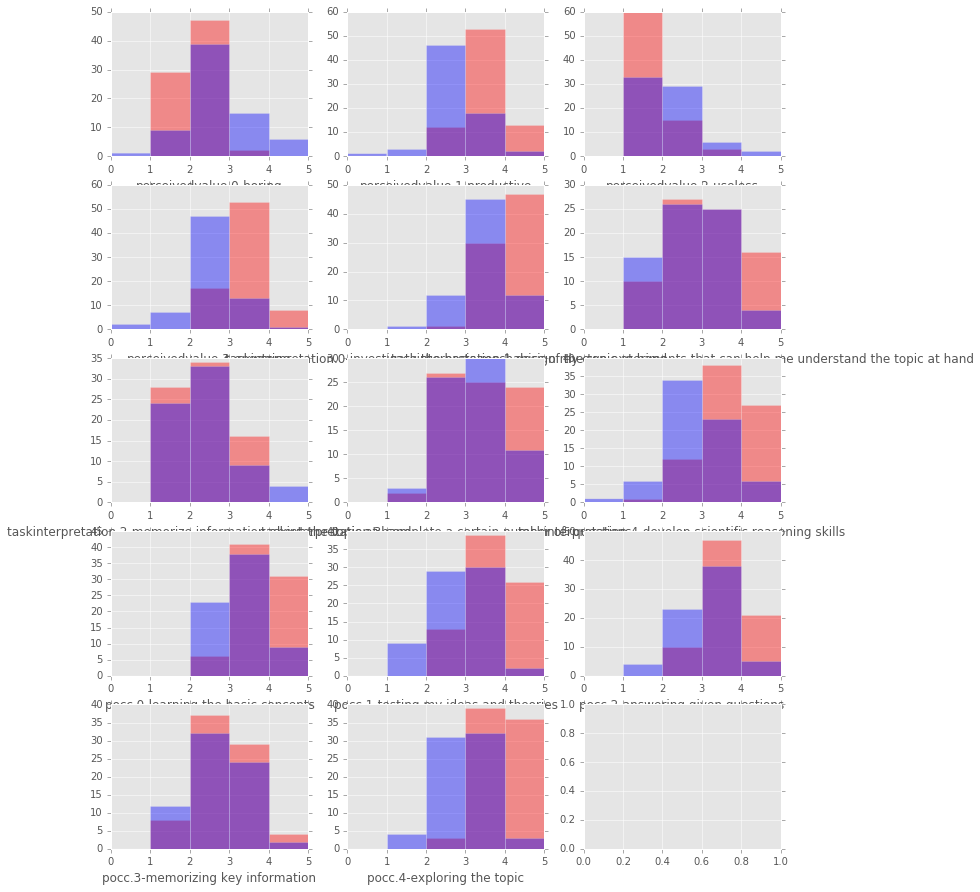

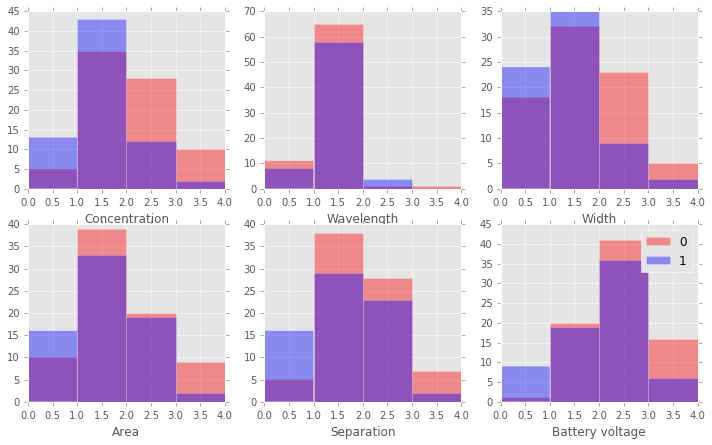

In [35]:
fig,axes = plt.subplots(nrows=len(att_columns)/3+1,ncols=3,figsize=(12,15))
for ax,col in zip(axes.reshape(-1),att_columns):
    sns.distplot(data[data['cluster_2_label']==0][col],ax=ax,bins=[0,1,2,3,4,5],kde=False,label='0',color='red');
    sns.distplot(data[data['cluster_2_label']==1][col],ax=ax,bins=[0,1,2,3,4,5],kde=False,label='1',color='blue');
plt.legend()
fig,axes = plt.subplots(nrows=2,ncols=3,figsize=(12,7))
for ax,col in zip(axes.reshape(-1),know_columns):
    sns.distplot(data[data['cluster_2_label']==0][col],ax=ax,bins=[0,1,2,3,4],kde=False,label='0',color='red');
    sns.distplot(data[data['cluster_2_label']==1][col],ax=ax,bins=[0,1,2,3,4],kde=False,label='1',color='blue');
plt.legend()

The blue group (contrary to red):
* has higher POCC and think it will be productive but boring
* has slightly higher incoming knowledge for Witdh and Concentration, but not much else.

# Exporting the data

In [36]:
data.head()

,[prior_lab] What lab courses are you presently taking or have taken in the past? Check all that apply. [High school level laboratory],[prior_lab] What lab courses are you presently taking or have taken in the past? Check all that apply. [First year undergraduate physics laboratory],[prior_lab] What lab courses are you presently taking or have taken in the past? Check all that apply. [First year undergraduate chemistry laboratory],[prior_lab] What lab courses are you presently taking or have taken in the past? Check all that apply. [Higher level chemistry labs],similar_L,similar_C,same_L,same_C,prior_number_virtual_labs,perceivedvalue.0-boring,perceivedvalue.1-productive,perceivedvalue.2-useless,perceivedvalue.3-engaging,taskinterpretation.0-investigate the basic mechanics of the topic at hand,taskinterpretation.1-design my own experiments that can help me understand the topic at hand,taskinterpretation.2-memorize information about the topic at hand,taskinterpretation.3-complete a certain number of questions,taskinterpretation.4-develop scientific reasoning skills,pocc.0-learning the basic concepts,pocc.1-testing my ideas and theories,pocc.2-answering given questions,pocc.3-memorizing key information,pocc.4-exploring the topic,sid,age,english.0-writing,english.1-reading,gender-Gender non conforming/non-binary,gender-Man,gender-Prefer not to answer,gender-Woman,major,year-1st year undergraduate,year-2nd year undergraduate,year-3rd year undergraduate,year-4th year undergraduate,second sim,sim_index,Area,Battery voltage,Concentration,Separation,Wavelength,Width,perceivedvalue.0-boring_reversed,perceivedvalue.2-useless_reversed,PC1,PC2,PC1_wo_pocc,PC2_wo_pocc,overall POCC,incoming_knowledge_L,incoming_knowledge_C,incoming_knowledge_all,incoming_knowledge_quant,cluster_2_label,cluster_3_label,cluster_4_label,cluster_5_label
0,1.0,1.0,1.0,0.0,0,0,0,0,2,3.0,2.0,1,2.0,3,2,3,2,2.0,3,3,3,2,3,77047160,19,3,3,0.0,0.0,0.0,1.0,*Non science or applied science major,1.0,0.0,0.0,0.0,C,2,1.0,1.0,1.0,0.0,1.0,1.0,1.0,3,0.997,0.704,1.486,0.107,14,3.0,2.0,5.0,3.0,1,2,0,3
1,1.0,1.0,0.0,0.0,0,0,0,0,0,2.0,4.0,1,3.0,4,4,3,4,4.0,3,2,2,2,3,23836160,19,2,2,0.0,1.0,0.0,0.0,Civil Engineering,1.0,0.0,0.0,0.0,L,2,0.0,3.0,1.0,0.0,1.0,1.0,2.0,3,-1.221,-0.611,-2.315,-1.158,12,3.0,3.0,6.0,2.0,0,1,1,4
2,0.0,1.0,1.0,0.0,0,0,0,0,1,1.0,2.0,1,2.0,2,2,2,3,2.0,3,3,3,3,2,64006159,21,2,2,0.0,0.0,0.0,1.0,*Undeclared,0.0,1.0,0.0,0.0,C,2,1.0,2.0,2.0,1.0,1.0,0.0,3.0,3,0.975,0.726,0.965,0.167,14,3.0,4.0,7.0,4.0,1,2,0,2
3,1.0,1.0,1.0,0.0,0,1,0,0,3,2.0,3.0,1,3.0,3,4,3,4,3.0,4,4,3,3,3,24566161,19,3,3,0.0,1.0,0.0,0.0,Engineering Physics,1.0,0.0,0.0,0.0,L,2,2.0,3.0,2.0,2.0,1.0,2.0,2.0,3,-1.703,0.744,-1.205,-0.694,17,5.0,7.0,12.0,8.0,0,0,2,0
4,0.0,1.0,0.0,0.0,1,0,0,0,2,2.0,3.0,1,3.0,4,2,1,3,4.0,3,3,3,2,4,46792161,19,3,3,0.0,1.0,0.0,0.0,Mechanical Engineering,1.0,0.0,0.0,0.0,C,2,3.0,3.0,2.0,3.0,1.0,2.0,2.0,3,-1.232,-0.610,-1.007,-0.404,15,5.0,9.0,14.0,10.0,0,0,2,0


In [37]:
export_data = data[['sid','overall POCC','PC1','PC2']].copy()
export_data.to_csv(os.path.join(BIG_FOLDER,'all_massaged_data\\incoming_attitudes.txt'), sep='\t', index=False)

# Picking out students

We want 8 students, 2 for each type:
* high attitude (cluster=0, PC1>2), high knowledge (incoming_knowledge_L ==8)
* high attitude (cluster=0, PC1>2), low knowledge (incoming_knowledge_L ==3)
* low attitude (cluster=1, PC1<-2), low knowledge (incoming_knowledge_L ==3)
* low attitude (cluster=1, PC1<-2), high knowledge (incoming_knowledge_L ==8)

On comment the following to save viz for 4 different types of students:

In [38]:
print 'a',data[(data['PC1']>2)&(data['incoming_knowledge_L']>=6)]['sid']
print 'b',data[(data['PC1']>2)&(data['incoming_knowledge_L']==2)]['sid']
print 'c',data[(data['PC1']<-2)&(data['incoming_knowledge_L']==3)]['sid']
print 'd',data[(data['PC1']<-2)&(data['incoming_knowledge_L']>=6)]['sid']

a Series([], Name: sid, dtype: int64)
b 15     10375163
33     19780165
128    10537160
133    17701169
Name: sid, dtype: int64
c 22    26984162
44    16752165
55    13654167
66    14302168
93    19023153
Name: sid, dtype: int64
d Series([], Name: sid, dtype: int64)


In [39]:
columns = ['sid',"Concentration","Wavelength","Width","perceivedvalue.0-boring","perceivedvalue.1-productive","taskinterpretation.1-design my own experiments that can help me understand the topic at hand","pocc.4-exploring the topic"]
exploration = data[data['sid'].isin([19989152,10537160,13654167,11929166])][columns]
exploration['Fakename'] = ['Saturn','Tatouine','Ursula','Venus']
exploration['knowledge'] = ['low','high','low','high']
exploration['incoming_attitude'] = ['low','high','high','low']
exploration.sort_values('Concentration',inplace=True)
exploration

,sid,Concentration,Wavelength,Width,perceivedvalue.0-boring,perceivedvalue.1-productive,taskinterpretation.1-design my own experiments that can help me understand the topic at hand,pocc.4-exploring the topic,Fakename,knowledge,incoming_attitude
55,13654167,1.0,1.0,1.0,1.0,3.0,3,4,Tatouine,high,high
128,10537160,1.0,1.0,0.0,3.0,2.0,1,1,Venus,high,low
10,11929166,3.0,3.0,1.0,2.0,3.0,3,4,Saturn,low,low
98,19989152,3.0,0.0,3.0,2.0,2.0,2,3,Ursula,low,high


In [41]:
%aimport utils_timeline_viz
matplotlib.style.use('ggplot')
matplotlib.rcParams['figure.figsize'] = 25, 15
from matplotlib.backends.backend_pdf import PdfPages

to_plot_beers = ['Pause','','Log axis','Inverse axis','Linear axis','Other axes','Abs vs. TrialNumber','Abs vs. Width','Abs vs. Concentration','','Graph edit axes','Graph add/del','Data Table delete','Record','','Wavelength','Width','Concentration','Detector','Laser toggle','','Absorbance']

def save_multipage_viz(students_to_explore):
    sim_name = {"beers":"Light absorbance",'capacitor':'Charge'}
    with PdfPages('multipage_timeline_viz_{0}.pdf'.format('_'.join([str(n) for n in students_to_explore['sid']]))) as pdf:
        for sim,to_plot in [('beers',to_plot_beers)]:#,('capacitor',to_plot_caps)]:
            for i,row in students_to_explore.iterrows():
                studentid = row['sid']
                name = row['Fakename']
                att = row['incoming_attitude']+' attitude'
                know = row['knowledge']+' knowledge'
                filename = find_student_log_file(sim,studentid)
                date = date = re.search(r'\d{7,8}_([\d\-\.\_]+)\.txt', filename).group(1)
                df = prep_parsing_data(filename)
                plt.figure(figsize=(20,12))
                plt.title("{1} \t {0} \t {2} \t {3}".format(name,sim_name[sim],att,know),fontsize=25)
                plot(df,to_plot,family_name_to_code,function_to_use,colors)
#                 plt.show()
                plt.tight_layout()
                pdf.savefig()
                plt.close()

save_multipage_viz(exploration)

D:\Applications\Anaconda2\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
